# Download Solar Prediction Images

Use this script to download images and create a movie of a camera during a day.

In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
from joblib import Parallel, delayed
import numpy as np
import os
import pandas as pd
import CameraNetwork
import CameraNetwork.global_settings as gs
import cv2
import Image
import ImageDraw
import pickle
import time
from tqdm import tqdm_notebook
import traceback

/home/amitibo/code/cameranetwork/CameraNetwork/transformation_matrices.py:1934: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [2]:
#BASE_PATH = "/home/amitibo/data/experiment_forecast_2017_08/"
BASE_PATH = "/VISL2_net/amitibo/experiment_forecast_2017_08/"

## Connect to Network

In [3]:
c = CameraNetwork.CLIclient()
proxy_params = CameraNetwork.retrieve_proxy_parameters()
c.start(proxy_params)
time.sleep(3)
SERVERS = c.client_instance.servers
print SERVERS

['110', '111', '112', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '219', 'cam_109bL', 'cam_110L', 'cam_110bL', 'cam_111bL', 'cam_111cL', 'cam_112L', 'cam_112bL', 'cam_113L', 'cam_114bL', 'cam_115L', 'cam_115bL', 'cam_116L', 'cam_117L', 'cam_118L', 'cam_118bL', 'cam_119L', 'cam_119bL', 'cam_120L']


## Settings

In [4]:
CAM = 219
DAY = 12
MONTH = 8
HDR = '3'
JPEG_QUALITY = 100

#
# For network camera
#
#RESOLUTION = 301
#VIDEO_RESOLUTION = (301, 301)

#
# For solar camera
#
RESOLUTION = 300
VIDEO_RESOLUTION = (400, 300)

ADD_TIMER_OVERLAY = True

### Download Test Image

In [4]:
df = c.query(
    server_id='{}'.format(CAM),
    query_day='{:02}/{}/2017'.format(MONTH, DAY),
    force=True
)[0]
print("Camera {} captured {} images on this day.".format(CAM, df.shape[0]))

Camera 219 captured 749 images on this day.


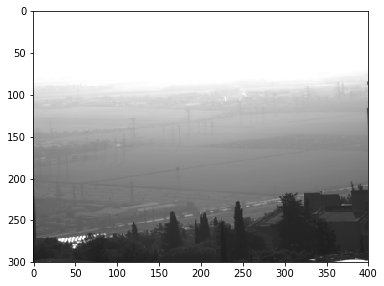

In [5]:
ind = df.loc[(slice(None), HDR), :].index[100]
img = c.seek('{}'.format(CAM), ind[0], ind[1], JPEG_QUALITY, RESOLUTION)[0][0]
plt.figure(figsize=(6, 6))
plt.imshow(img)

In [55]:
df = c.query(
    server_id='{}'.format(123),
    query_day='{:02}/{}/2017'.format(MONTH, DAY),
    force=True
)[0]
print("Camera {} captured {} images on this day.".format(123, df.shape[0]))

Camera 219 captured 3342 images on this day.


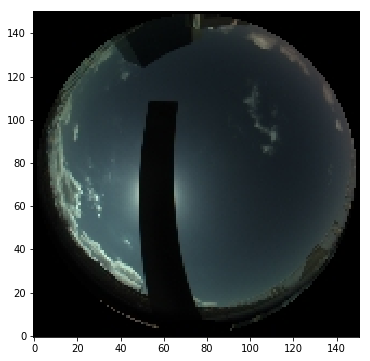

In [64]:
ind = df.loc[(slice(None), "3"), :].index[501]
img = c.seek('{}'.format(123), ind[0], ind[1], JPEG_QUALITY, 151)[0][0]
plt.figure(figsize=(6, 6))
plt.imshow(img, origin="bottom")

In [62]:
img.dtype

dtype('uint8')

## Download Images

### First Download from the Solar Camera

In [7]:
CAM = 219
DAY = 16
MONTH = 8
HDR = '0'
JPEG_QUALITY = 100

#
# For network camera
#
#RESOLUTION = 301
#VIDEO_RESOLUTION = (301, 301)

#
# For solar camera
#
RESOLUTION = 300
VIDEO_RESOLUTION = (400, 300)

ADD_TIMER_OVERLAY = True

In [8]:
df = c.query(
    server_id='{}'.format(CAM),
    query_day='{:02}/{}/2017'.format(MONTH, DAY),
    force=True
)[0]
print("Camera {} captured {} images on this day.".format(CAM, df.shape[0]))

Camera 219 captured 853 images on this day.


In [9]:
dst_path = os.path.join(BASE_PATH, "cam_{}".format(CAM), "2017_{}_{:02}".format(MONTH, DAY))
if not os.path.exists(dst_path):
    os.makedirs(dst_path)

In [10]:
rows = []
for ind in tqdm_notebook(df.loc[(slice(None), HDR), :].index):
    try:
        row = df.loc[ind]
        
        img_name = os.path.split(row["path"])[1][:-4] + ".jpg"
        img_path = os.path.join(dst_path, img_name)
        
        img = c.seek('{}'.format(CAM), ind[0], ind[1], JPEG_QUALITY, RESOLUTION)[0][0]
        img = Image.fromarray(img)
        img.save(img_path, format='JPEG', subsampling=0, quality=100)
        
        row["path"] = img_path
        rows.append(row)

    except Exception, e:
        traceback.print_exc() 

Widget Javascript not detected.  It may not be installed or enabled properly.


/home/amitibo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
df2 = pd.DataFrame(rows)
df2.to_pickle(os.path.join(dst_path, "df.pkl"))

### Same as above but in a loop

In [3]:
CAM = 219
MONTH = 8
HDR = '0'
JPEG_QUALITY = 100

#
# For solar camera
#
RESOLUTION = 300

for DAY in tqdm_notebook(range(17, 25)):
    #
    # Get the list of images
    #
    df = c.query(
        server_id='{}'.format(CAM),
        query_day='{:02}/{}/2017'.format(MONTH, DAY),
        force=True
    )[0]
    print("Camera {} captured {} images on day {}.".format(CAM, df.shape[0], DAY))

    #
    # Prepare the destination folder.
    #
    dst_path = os.path.join(BASE_PATH, "cam_{}".format(CAM), "2017_{}_{:02}".format(MONTH, DAY))
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)

    #
    # Download the images.
    #
    rows = []
    for ind in tqdm_notebook(df.loc[(slice(None), HDR), :].index):
        try:
            row = df.loc[ind]

            img_name = os.path.split(row["path"])[1][:-4] + ".jpg"
            img_path = os.path.join(dst_path, img_name)

            img = c.seek('{}'.format(CAM), ind[0], ind[1], JPEG_QUALITY, RESOLUTION)[0][0]
            img = Image.fromarray(img)
            img.save(img_path, format='JPEG', subsampling=0, quality=JPEG_QUALITY)

            row["path"] = img_path
            rows.append(row)

        except Exception, e:
            traceback.print_exc()

    #
    # Save a dataframe for the day.
    #
    df2 = pd.DataFrame(rows)
    df2.to_pickle(os.path.join(dst_path, "df.pkl"))

Camera 219 captured 734 images on day 17.


/home/amitibo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Traceback (most recent call last):
  File "<ipython-input-3-794c2fa1d666>", line 41, in <module>
    img = c.seek('{}'.format(CAM), ind[0], ind[1], JPEG_QUALITY, RESOLUTION)[0][0]
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 516, in seek
    resolution=resolution
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 387, in send_message
    "Server {} raised Exception:\n{}".format(server_id, args_answer[0])
Exception: Server 219 raised Exception:
Calling the cmd handler caused an error:
Traceback (most recent call last):
  File "/home/odroid/code/cameranetwork/CameraNetwork/server.py", line 320, in _on_request
    answer = yield cb(*args, **kwds)
  File "

Camera 219 captured 848 images on day 18.


Camera 219 captured 847 images on day 19.


Camera 219 captured 580 images on day 20.


Traceback (most recent call last):
  File "<ipython-input-3-794c2fa1d666>", line 41, in <module>
    img = c.seek('{}'.format(CAM), ind[0], ind[1], JPEG_QUALITY, RESOLUTION)[0][0]
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 516, in seek
    resolution=resolution
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 387, in send_message
    "Server {} raised Exception:\n{}".format(server_id, args_answer[0])
Exception: Server 219 raised Exception:
Calling the cmd handler caused an error:
Traceback (most recent call last):
  File "/home/odroid/code/cameranetwork/CameraNetwork/server.py", line 320, in _on_request
    answer = yield cb(*args, **kwds)
  File "/usr/local/lib/python2.7/dist-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/usr/local/lib/python2.7/dist-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "/usr/local/lib/python2.7/dist-packages/tornado/gen.py", 

Camera 219 captured 632 images on day 21.


Traceback (most recent call last):
  File "<ipython-input-3-794c2fa1d666>", line 41, in <module>
    img = c.seek('{}'.format(CAM), ind[0], ind[1], JPEG_QUALITY, RESOLUTION)[0][0]
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 516, in seek
    resolution=resolution
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 387, in send_message
    "Server {} raised Exception:\n{}".format(server_id, args_answer[0])
Exception: Server 219 raised Exception:
Calling the cmd handler caused an error:
Traceback (most recent call last):
  File "/home/odroid/code/cameranetwork/CameraNetwork/server.py", line 320, in _on_request
    answer = yield cb(*args, **kwds)
  File "/usr/local/lib/python2.7/dist-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/usr/local/lib/python2.7/dist-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "/usr/local/lib/python2.7/dist-packages/tornado/gen.py", 

Camera 219 captured 844 images on day 22.


Camera 219 captured 842 images on day 23.


Camera 219 captured 842 images on day 24.


## Download from the rest of the Cameras

In [33]:
remote_servers = [server_id for server_id in c.servers_list if not server_id.endswith("L")]
remote_servers = remote_servers[:-1]

In [34]:
remote_servers

['110',
 '111',
 '112',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123']

In [36]:
def download_images(client, server_id, day, hdr, resolution):
    #
    # Get the list of images.
    #
    try:
        df = client.query(
            server_id='{}'.format(server_id),
            query_day='{:02}/{}/2017'.format(MONTH, day),
            force=True
        )[0]
    except Exception, e:
        traceback.print_exc()
        return
        
    print("Camera {} captured {} images on this day.".format(server_id, df.shape[0]))
    
    #
    # Setup the dst path.
    #
    dst_path = os.path.join(BASE_PATH, "cam_{}".format(server_id), "2017_{}_{:02}".format(MONTH, day))
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    
    #
    # Iterate the images.
    #
    rows = []
    for ind in df.loc[(slice(None), hdr), :].index:
        try:
            row = df.loc[ind]

            img_name = os.path.split(row["path"])[1][:-4] + ".jpg"
            data_name = os.path.split(row["path"])[1][:-4] + ".pkl"
            
            img_path = os.path.join(dst_path, img_name)
            data_path = os.path.join(dst_path, data_name)
            
            tries_cnt = 0
            for i in range(2):
                #
                # Try twice
                #
                try:
                    imgs, datas = c.seek('{}'.format(server_id), ind[0], ind[1], JPEG_QUALITY, resolution)
                    break
                except Exception, e:
                    if tries_cnt == 0:
                        print("Failed to download image from camera {} will try again:\n{}".format(server_id, traceback.format_exc()))
                        tries_cnt += 1
                        pass
                    else:
                        raise

            img = Image.fromarray(imgs[0])
            img.save(img_path, format='JPEG', subsampling=0, quality=100)

            with open(data_path, "wb") as f:
                pickle.dump(datas[0], f)

            row["path"] = img_path
            row["exposure"] = datas[0].exposure_us

            rows.append(row)
        except Exception, e:
            print("Failed twice to download image from camera {}:\n{}".format(server_id, traceback.format_exc()))

    #
    # Save the dataframe.
    #
    df2 = pd.DataFrame(rows)
    df2.to_pickle(os.path.join(dst_path, "df.pkl"))

In [38]:
#DAY = 14
MONTH = 8
HDR = '3'
JPEG_QUALITY = 100

#
# For solar camera
#
RESOLUTION = 300

In [39]:
for day in range(14, 15):
    print("Downloading day: {}".format(day))
    Parallel(backend="threading", n_jobs=len(remote_servers))(
        delayed(download_images)(c, server_id, day, HDR, RESOLUTION) for server_id in remote_servers)

Traceback (most recent call last):
  File "<ipython-input-36-08f269de5d6b>", line 9, in download_images
    force=True
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 489, in query
    force=force
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 387, in send_message
    "Server {} raised Exception:\n{}".format(server_id, args_answer[0])
Exception: Server 112 raised Exception:
Calling the cmd handler caused an error:
Traceback (most recent call last):
  File "/home/odroid/code/cameranetwork/CameraNetwork/server.py", line 414, in _on_request
    answer = yield cb(*args, **kwds)
  File "/home/odroid/.local/lib/python2.7/site-packages/tornado/gen.py", line 1008, in run
    value = future.result()
  File "/home/odroid/.local/lib/python2.7/site-packages/tornado/concurrent.py", line 232, in result
    raise_exc_info(self._exc_info)
  File "/home/odroid/.local/lib/python2.7/site-packages/tornado/gen.py", line 267, in wrapper
    result = func(*arg

Camera 114 captured 2935 images on this day.
Camera 123 captured 3349 images on this day.
Camera 120 captured 2992 images on this day.
Camera 110 captured 3349 images on this day.
Camera 115 captured 3349 images on this day.
Camera 111 captured 3349 images on this day.
Camera 119 captured 3349 images on this day.
Camera 118 captured 3253 images on this day.
Camera 122 captured 3345 images on this day.
Camera 117 captured 3349 images on this day.
Camera 116 captured 3349 images on this day.


/home/amitibo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/amitibo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Failed to download image from camera 120 will try again:
Traceback (most recent call last):
  File "<ipython-input-36-08f269de5d6b>", line 44, in download_images
    imgs, datas = c.seek('{}'.format(server_id), ind[0], ind[1], JPEG_QUALITY, resolution)
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 516, in seek
    resolution=resolution
  File "/home/amitibo/code/cameranetwork/CameraNetwork/client.py", line 387, in send_message
    "Server {} raised Exception:\n{}".format(server_id, args_answer[0])
Exception: Server 120 raised Exception:
Calling the cmd handler caused an error:
Traceback (most recent call last):
  File "/home/odroid/code/cameranetwork/CameraNetwork/server.py", line 414, in _on_request
    answer = yield cb(*args, **kwds)
  File "/home/odroid/.local/lib/python2.7/site-packages/tornado/gen.py", line 1008, in run
    value = future.result()
  File "/home/odroid/.local/lib/python2.7/site-packages/tornado/concurrent.py", line 232, in result
    rais

## Like above but for specfic days/servers.

In [42]:
specific_servers = (114, 120)
specific_days = (15, 16, 17, 23, 24)

for day in specific_days:
    print("Downloading day: {}".format(day))
    Parallel(backend="threading", n_jobs=len(specific_servers))(
        delayed(download_images)(c, server_id, day, HDR, RESOLUTION) for server_id in specific_servers)

Camera 114 captured 3010 images on this day.
Camera 120 captured 2963 images on this day.


/home/amitibo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/amitibo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Camera 114 captured 1777 images on this day.
Camera 120 captured 2971 images on this day.
Camera 120 captured 2969 images on this day.
Camera 114 captured 3001 images on this day.
Camera 120 captured 2940 images on this day.
Camera 114 captured 2956 images on this day.
Camera 120 captured 2861 images on this day.
Camera 114 captured 2956 images on this day.
